In [2]:
import pandas as pd
import numpy as np

### Preproc for RF

In [222]:
df = pd.read_csv('approved1.csv')

In [223]:
def clean(df):
    df = df.dropna(subset=['issue_d', # If there is no issue date, this is not a "good" record
                              'annual_inc',
                              'dti',
                              'open_acc',
                              'pub_rec',
                              'pub_rec_bankruptcies',
                              'term'
                              ])
    df['id'] = df['id'].astype(int)
    df = df.set_index('id')
    df = df.loc[df['grade'].isin(['A','B','C','D','E']),:] # Remove grades in F or G
    df = df.loc[df['loan_status'].isin(['Charged Off','Fully Paid']),:] # Remove loans that have not finalized
    df = df[df.annual_inc < 2e7] # Remove outliers
    df['emp_length'] = df['emp_length'].fillna('-1 years') # Impute -1 years when no employee length is given
    return df

In [224]:
def make_binary(df):
    df['application_type_indiv']= np.where(df['application_type']=='Individual',1,0)
    df['disbursement_method_cash']= np.where(df['disbursement_method'] =='Cash',1,0)
    df['loan_status'] = np.where(df['loan_status']=='Charged Off',0, 1)
    df['initial_list_status_w']= np.where(df['initial_list_status']=='w',1, 0)
    return df

In [225]:
clean(df)
make_binary(df)

,id,addr_state,annual_inc,application_type,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,...,pub_rec_bankruptcies,purpose,sub_grade,term,verification_status,zip_code,loan_status,application_type_indiv,disbursement_method_cash,initial_list_status_w
0,54734,CA,85000.0,Individual,Cash,19.48,1994-02-01,< 1 year,NaN,739.0,...,0.0,debt_consolidation,B4,36 months,Verified,941xx,1,1,1,0
1,55716,WA,30784.0,Individual,Cash,16.96,2003-04-01,< 1 year,Receptionist,669.0,...,1.0,debt_consolidation,E4,36 months,Not Verified,984xx,1,1,1,1
2,55742,NY,65000.0,Individual,Cash,14.29,2000-10-01,< 1 year,CNN,709.0,...,0.0,credit_card,B5,36 months,Not Verified,112xx,1,1,1,0
3,56121,NE,65000.0,Individual,Cash,10.84,2002-03-01,10+ years,Maintenance,709.0,...,1.0,home_improvement,A2,36 months,Not Verified,686xx,0,1,1,1
4,56705,MO,33500.0,Individual,Cash,18.38,1997-11-01,10+ years,Academic Admin,704.0,...,0.0,debt_consolidation,B3,36 months,Source Verified,658xx,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303078,145620416,ID,200000.0,Individual,Cash,2.62,2006-02-01,10+ years,Cabinet maker,729.0,...,0.0,house,A3,36 months,Not Verified,836xx,1,1,1,1
1303079,145622746,FL,71000.0,Individual,Cash,30.39,2002-09-01,4 years,Event Manager,709.0,...,0.0,credit_card,C5,36 months,Source Verified,347xx,1,1,1,0
1303080,145623694,WA,57000.0,Individual,Cash,22.18,1995-04-01,4 years,Front office Lead,739.0,...,0.0,debt_consolidation,D1,60 months,Not Verified,981xx,1,1,1,1
1303081,145627026,WA,100000.0,Joint App,Cash,18.92,1999-02-01,10+ years,Teacher,754.0,...,0.0,credit_card,A3,36 months,Not Verified,982xx,1,0,1,1


In [226]:
df['emp_length'].isna().sum()

76061

In [227]:
#fix emp_length column

# Impute -1 years when no employee length is given
df['emp_length'] = df['emp_length'].fillna('-1 years')

df['emp_length']= np.where(df['emp_length']=='-1 years',1,0)

#fix term column
df['term'] = df.term.str.extract('(\d+)').astype(int)

In [228]:
df['emp_length'].value_counts()

0    1227022
1      76061
Name: emp_length, dtype: int64

In [229]:
#feature engineering: days since first credit
df['earliest_cr_line']=pd.to_datetime(df['earliest_cr_line'])
df['issue_d']=pd.to_datetime(df['issue_d'])

In [230]:
df= df.loc[df['issue_d'].dt.year.between(2007,2014)]

In [231]:
df['issue_d']

0        2009-08-01
2        2008-05-01
5        2014-08-01
6        2010-03-01
7        2009-11-01
            ...    
438139   2014-12-01
438140   2014-12-01
438147   2014-12-01
438149   2014-12-01
438849   2014-12-01
Name: issue_d, Length: 434929, dtype: datetime64[ns]

In [232]:
df['days_since_first_credit'] = (df.issue_d - df.earliest_cr_line).dt.days

<ipython-input-232-d3ac7e9bd6be>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [233]:
df['days_since_first_credit'].value_counts()

4383     2591
4748     2373
4018     2200
5479     2186
4444     1958
         ... 
18750       1
17074       1
21185       1
19967       1
18779       1
Name: days_since_first_credit, Length: 2435, dtype: int64

In [234]:
#create new column averaging fico range
df['fico_avg']= (df['fico_range_low'] + df['fico_range_high'])/2

<ipython-input-234-000d70751c18>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [235]:
#drops

#drop columns we changed (and grade)
df = df.drop(['fico_range_low','fico_range_high','application_type','disbursement_method','initial_list_status','grade','issue_d','earliest_cr_line'], axis=1)

#not dealt with, many NA
df.drop(['emp_title'], axis=1, inplace=True)

#dont want in model
df.drop(['id'], axis=1, inplace=True)

#new drops - not signif?
df.drop(['application_type_indiv','disbursement_method_cash'], axis=1, inplace=True)

#drop missing in zip_code and emp_length
df=df.loc[df.zip_code.notnull()]
df=df.loc[df.emp_length.notnull()]

In [236]:
#check missingness
df.isna().sum()

addr_state                 0
annual_inc                 0
dti                        0
emp_length                 0
home_ownership             0
installment                0
int_rate                   0
loan_amnt                  0
open_acc                   0
pub_rec                    0
pub_rec_bankruptcies       0
purpose                    0
sub_grade                  0
term                       0
verification_status        0
zip_code                   0
loan_status                0
initial_list_status_w      0
days_since_first_credit    0
fico_avg                   0
dtype: int64

In [237]:
#label encode rest of columns

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df['sub_grade'] = le.fit_transform(df['sub_grade'])
df['addr_state'] = le.fit_transform(df['addr_state'])
df['home_ownership'] = le.fit_transform(df['home_ownership'])
df['purpose'] = le.fit_transform(df['purpose'])
df['verification_status'] = le.fit_transform(df['verification_status'])
df['zip_code'] = le.fit_transform(df['zip_code'])

In [238]:
#final check of data types
df.dtypes

addr_state                   int64
annual_inc                 float64
dti                        float64
emp_length                   int64
home_ownership               int64
installment                float64
int_rate                   float64
loan_amnt                  float64
open_acc                   float64
pub_rec                    float64
pub_rec_bankruptcies       float64
purpose                      int64
sub_grade                    int64
term                         int64
verification_status          int64
zip_code                     int64
loan_status                  int64
initial_list_status_w        int64
days_since_first_credit      int64
fico_avg                   float64
dtype: object

In [283]:
# take a random sample 
sample= df.sample(n=100000)
sample

,addr_state,annual_inc,dti,emp_length,home_ownership,installment,int_rate,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,verification_status,zip_code,loan_status,initial_list_status_w,days_since_first_credit,fico_avg
263296,4,110000.0,10.04,0,1,287.75,14.16,8400.0,7.0,3.0,1.0,2,11,36,1,836,1,0,9921,677.0
181298,47,35000.0,23.66,0,5,306.16,13.67,9000.0,11.0,1.0,1.0,2,9,36,2,479,1,0,5844,672.0
252985,19,75000.0,28.40,0,5,566.44,14.64,24000.0,8.0,0.0,0.0,2,12,60,0,15,0,0,5906,697.0
343419,4,65000.0,13.26,0,5,475.57,20.20,17875.0,16.0,0.0,0.0,9,22,60,1,790,0,1,4383,672.0
221188,9,91000.0,6.73,0,1,481.69,9.67,15000.0,6.0,0.0,0.0,2,5,36,0,306,1,0,6362,682.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60574,4,55000.0,16.10,0,4,412.06,14.33,12000.0,7.0,0.0,0.0,2,10,36,0,810,1,0,7032,672.0
354426,34,59000.0,21.91,0,5,255.04,9.17,8000.0,25.0,1.0,1.0,1,5,36,0,410,0,0,3865,692.0
388004,49,60000.0,7.42,0,1,306.96,8.39,15000.0,15.0,0.0,0.0,1,4,60,2,730,1,1,3866,692.0
169449,18,65000.0,8.88,0,1,132.00,11.55,4000.0,10.0,0.0,0.0,2,7,36,1,620,1,0,4779,687.0


In [240]:
df.shape

(434929, 20)

## Random Forest Classifier

In [314]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold

In [315]:
loan_targ = pd.Series(df.loan_status, name='target')
loan_feature = df.drop('loan_status',axis=1)

skf = StratifiedKFold(n_splits=5, shuffle=True)
rfc= RandomForestClassifier(class_weight='balanced')

In [260]:
#first test some parameters from random grid search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = np.linspace(10, 110, 11)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [261]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [285]:
rf_random = RandomizedSearchCV(estimator = rfc, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = skf, 
                               verbose=2, random_state=42, n_jobs = -1)

In [316]:
#train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(loan_feature, 
                                                loan_targ, stratify= loan_targ)

In [57]:
rf_random.fit(Xtrain, ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 19.5min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.]),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [58]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50.0,
 'bootstrap': True}

In [317]:
#use random grid search param results - tuned
grid_para_forest = {'n_estimators': [1000],
 'max_features': ['sqrt'],
 'max_depth': [10]}

In [318]:
grid_search_forest = GridSearchCV(estimator=rfc, 
                                     param_grid=grid_para_forest, 
                                     cv=skf, verbose=2)

%time grid_search_forest.fit(Xtrain, ytrain)  

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time= 4.7min
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time= 4.6min
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time= 4.6min
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time= 4.5min
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time= 4.6min
CPU times: user 28min 22s, sys: 11.5 s, total: 28min 34s
Wall time: 28min 45s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [10], 'max_features': ['sqrt'],
                         'n_estimators': [1000]},
             verbose=2)

In [319]:
grid_search_forest.best_params_

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}

In [320]:
best_rf = grid_search_forest.best_estimator_

In [321]:
best_rf.score(Xtrain, ytrain)

0.6517185986339501

In [322]:
best_rf.score(Xtest, ytest)

0.6388033071836517

In [323]:
y_pred = best_rf.predict(Xtest)

### Evaluate metrics

In [324]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [325]:
print('MAE:', metrics.mean_absolute_error(ytest, y_pred))  
print('MSE:', metrics.mean_squared_error(ytest, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))

MAE: 0.3611966928163483
MSE: 0.3611966928163483
RMSE: 0.6009964166418534


In [326]:
metrics.f1_score(ytest, y_pred, labels=np.unique(y_pred))

0.7474275865617122

In [327]:
print(confusion_matrix(ytest,y_pred))
print(classification_report(ytest,y_pred))
print(accuracy_score(ytest, y_pred))

[[11348  6296]
 [32978 58111]]
              precision    recall  f1-score   support

           0       0.26      0.64      0.37     17644
           1       0.90      0.64      0.75     91089

    accuracy                           0.64    108733
   macro avg       0.58      0.64      0.56    108733
weighted avg       0.80      0.64      0.69    108733

0.6388033071836517


In [350]:
threshold = .55

predicted_proba = best_rf.predict_proba(Xtest)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

print(accuracy_score(ytest, predicted))
print(confusion_matrix(ytest,predicted))
print(classification_report(ytest,predicted))

0.5657803978552969
[[13086  4558]
 [42656 48433]]
              precision    recall  f1-score   support

           0       0.23      0.74      0.36     17644
           1       0.91      0.53      0.67     91089

    accuracy                           0.57    108733
   macro avg       0.57      0.64      0.51    108733
weighted avg       0.80      0.57      0.62    108733



In [348]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

0.6405616477011945


Text(0.5, 0, 'False Positive')

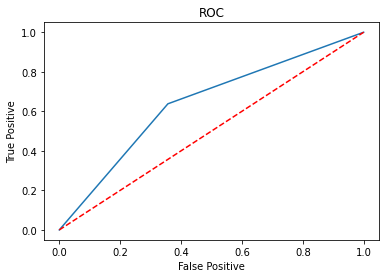

In [401]:
import matplotlib.pyplot as plt
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = %0.2f'% roc_auc)
plt.plot([0,1],[0,1],'--r')
plt.ylabel('True Positive')
plt.xlabel('False Positive')

### Investigate

In [332]:
Xtest1= Xtest.copy()

In [333]:
Xtest1['y_pred']=y_pred

In [334]:
Xtest1['ytrue']=ytest

In [335]:
Xtest1

,addr_state,annual_inc,dti,emp_length,home_ownership,installment,int_rate,loan_amnt,open_acc,pub_rec,...,purpose,sub_grade,term,verification_status,zip_code,initial_list_status_w,days_since_first_credit,fico_avg,y_pred,ytrue
317928,16,82000.0,13.52,0,1,584.37,6.03,19200.0,16.0,0.0,...,2,0,36,0,600,1,8340,782.0,1,1
309367,3,100000.0,17.33,0,1,408.06,9.17,12800.0,13.0,0.0,...,1,5,36,0,750,0,11474,712.0,1,1
252461,40,35000.0,11.42,0,1,206.50,16.59,5825.0,6.0,0.0,...,2,15,36,0,513,1,1826,692.0,0,1
436907,42,74000.0,8.53,0,1,306.45,6.49,10000.0,9.0,0.0,...,4,1,36,0,668,0,5388,742.0,1,1
151771,42,95000.0,7.28,0,1,400.59,12.35,12000.0,12.0,0.0,...,2,8,36,2,669,1,4625,697.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201057,33,70000.0,20.92,0,5,312.91,7.90,10000.0,13.0,0.0,...,12,3,36,0,88,0,5084,747.0,1,1
345980,33,95000.0,25.68,0,1,501.74,12.49,15000.0,14.0,0.0,...,1,9,36,1,114,0,4870,707.0,1,0
376972,42,41000.0,16.10,1,1,316.25,17.57,8800.0,24.0,0.0,...,2,18,36,2,688,0,7335,667.0,0,1
132326,4,30000.0,20.60,0,5,214.73,17.27,6000.0,14.0,0.0,...,9,14,36,0,828,0,1765,677.0,0,1


In [336]:
Xtest1['ytrue'].value_counts()

1    91089
0    17644
Name: ytrue, dtype: int64

In [337]:
Xtest1['y_pred'].value_counts()

1    64407
0    44326
Name: y_pred, dtype: int64

In [375]:
Xtest2 = Xtest1.loc[Xtest1['ytrue']==0]
Xtest3= Xtest2.loc[Xtest2['y_pred']==1]
Xtest3['y_pred'].value_counts()

1    6296
Name: y_pred, dtype: int64

In [364]:
import seaborn as sns

In [388]:
df['sub_grade'].value_counts()

7     31163
8     29802
6     26216
10    26159
11    25797
9     24695
12    24292
13    23001
5     22509
4     21475
14    21186
3     18964
15    18258
16    16075
17    14016
18    13210
2     12517
1     10914
19    10852
0     10528
20     8388
21     8064
22     6498
23     5576
24     4774
Name: sub_grade, dtype: int64

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

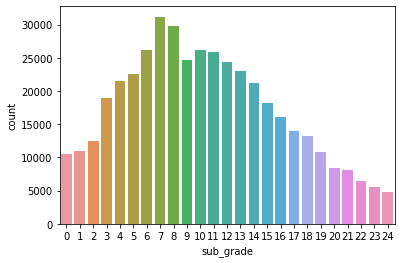

In [392]:
sns.countplot(x= df['sub_grade'])

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

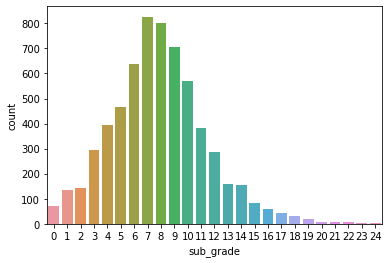

In [376]:
sns.countplot(x= Xtest3['sub_grade'])

In [387]:
df['term'].value_counts()

36    331702
60    103227
Name: term, dtype: int64

<AxesSubplot:xlabel='term', ylabel='count'>

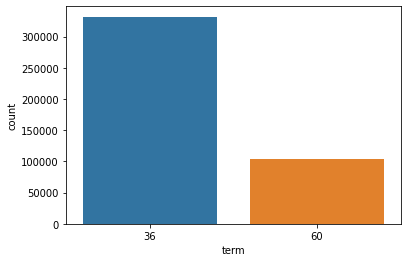

In [393]:
sns.countplot(x=df['term'])

<AxesSubplot:xlabel='term', ylabel='count'>

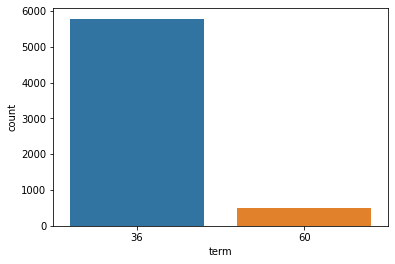

In [379]:
sns.countplot(x= Xtest3['term'])

<AxesSubplot:xlabel='addr_state', ylabel='count'>

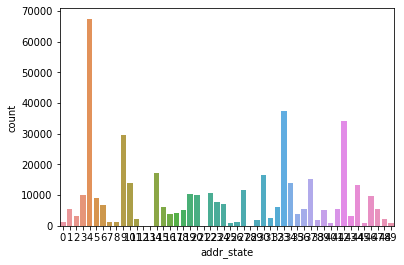

In [394]:
sns.countplot(x= df['addr_state'])

<AxesSubplot:xlabel='addr_state', ylabel='count'>

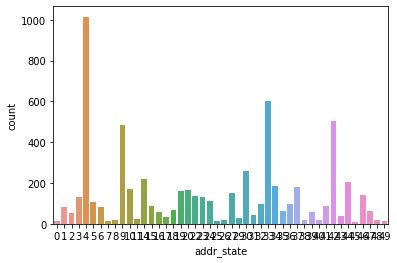

In [386]:
sns.countplot(x= Xtest3['addr_state'])

<AxesSubplot:xlabel='purpose', ylabel='count'>

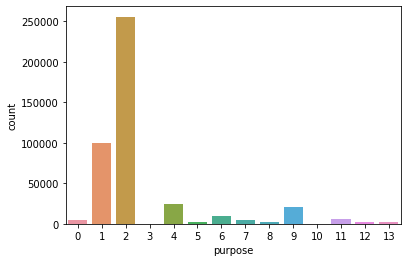

In [395]:
sns.countplot(x= df['purpose'])

<AxesSubplot:xlabel='purpose', ylabel='count'>

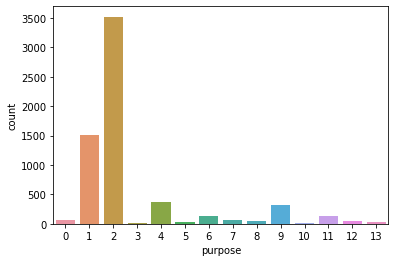

In [389]:
sns.countplot(x= Xtest3['purpose'])

In [391]:
df['purpose'].value_counts()

2     255708
1      99484
4      24662
9      20947
6       9244
11      5870
0       5150
7       4184
8       2639
12      2344
13      2146
5       1940
10       309
3        302
Name: purpose, dtype: int64

### Feature importance

In [380]:
feat_imp = pd.Series(best_rf.feature_importances_, index = Xtrain.columns)
feat_imp.sort_values(ascending=False).head(25)

sub_grade                  0.265839
int_rate                   0.230433
term                       0.119010
annual_inc                 0.071333
dti                        0.056085
fico_avg                   0.052780
installment                0.034760
loan_amnt                  0.031057
days_since_first_credit    0.027313
zip_code                   0.024159
open_acc                   0.017032
addr_state                 0.014911
home_ownership             0.013431
verification_status        0.013412
purpose                    0.012927
emp_length                 0.007066
initial_list_status_w      0.003586
pub_rec                    0.002760
pub_rec_bankruptcies       0.002108
dtype: float64

In [381]:
import pandas as pd
import plotly.express as px

def get_feature_importance(model, X: pd.DataFrame) -> pd.Series:
    """
    Given a tree-based model and a dataframe with column names,
    this will return a pandas series with the feature importances.
    """
    feats = pd.Series(model.feature_importances_, X.columns)
    feats = feats[feats>0].sort_values(ascending=False)
    return feats

def graph_importance(feats: pd.Series, model_name: str =''):
    """
    Given a pandas Series of feature importances and an optional model name,
    this will return a Plotly bar graph showing the importances.
    """
    fig = px.bar(feats[feats>0].sort_values(ascending=False), orientation='h', title=f'{model_name} Feature Importance',
            labels={
                     "index": "Feature",
                     "value": "Importance Value"
                 })
    fig.update_layout(showlegend=False) 
    return fig

In [382]:
get_feature_importance(best_rf, Xtrain)

sub_grade                  0.265839
int_rate                   0.230433
term                       0.119010
annual_inc                 0.071333
dti                        0.056085
fico_avg                   0.052780
installment                0.034760
loan_amnt                  0.031057
days_since_first_credit    0.027313
zip_code                   0.024159
open_acc                   0.017032
addr_state                 0.014911
home_ownership             0.013431
verification_status        0.013412
purpose                    0.012927
emp_length                 0.007066
initial_list_status_w      0.003586
pub_rec                    0.002760
pub_rec_bankruptcies       0.002108
dtype: float64

In [383]:
graph_importance(feat_imp, 'Random Forest')